#### Imports

In [22]:
# Import classes from other files
from utils.dataStorage import dataStorage
from utils.model import EdgeModel

In [23]:
# Imports for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import for file handling
from pathlib import Path
import numpy as np

# Torch imports
import torch
from torch.nn.functional import relu, binary_cross_entropy_with_logits
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv

#### Obtaining the training data

In [27]:
# Load all batches into dataset a dataStorage class
dataset = dataStorage(Path("../dataset/batch_1_" + str(9)))
for i in range(9):
    dataset.append(Path("../dataset/batch_1_" + str(i)))

# Batch dataset using DataLoader with shuffling
loader = DataLoader(dataset, batch_size=64, shuffle=True)

#### Preliminary analysis of training data

In [47]:
print("Number of graphs in set:", len(dataset))
print("Set of keys in each graph", dataset[0].keys)

Number of graphs in set: 9996
Set of keys in each graph ['edge_attr', 'x', 'y', 'edge_index']


In [44]:
print("Number of node features:", dataset[0].num_node_features)
print("Number of edge features:", dataset[0].num_edge_features)
print("Is this graph undirected? ", dataset[0].is_undirected())

Number of node features: 6
Number of edge features: 4
Is this graph undirected?  False


In [50]:
edges_average, nodes_average = 0, 0
for i in range(100):
    edges_average += dataset[i].num_edges
    nodes_average += dataset[i].num_nodes

print("Average number of nodes in first 100 graphs:", nodes_average/100)
print("Average number of edges in first 100 graphs:", edges_average/100)

Average number of nodes in first 100 graphs: 289.96
Average number of edges in first 100 graphs: 3619.12


In [51]:
percent_average = 0
for i in range(100):
    percent_average += (dataset[i]['y'].sum()/len(dataset[i]['y'])).item()

print("Proportion of edges that are True in first 100 graphs:", percent_average/100)

Proportion of edges that are True in first 100 graphs: 0.2083113230764866


We can make a few observations from these results. First, 

### Train Model

In [21]:
device = torch.device('cpu')
model = EdgeModel(dataset[0]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-4)

model.train()
loss_values = []
epoch_values = []
ref_values = []
ref_values = []
val = 0

for batch in loader:
    val += 1
    data = batch.to(device)
    optimizer.zero_grad()
    out = model(data)
    ones = 0.1 * torch.ones(len(out))
    zeros = torch.zeros(len(out))
    loss = binary_cross_entropy_with_logits(out, data.y)
    ref1 = binary_cross_entropy_with_logits(ones, data.y)
    ref2 = binary_cross_entropy_with_logits(zeros, data.y)
    loss_values.append(loss.item())
    epoch_values.append(val)
    ref_values.append(ref1)
    loss.backward()
    optimizer.step()

model.eval()
ref = np.mean(ref_values)
print("Final Loss: " + str(loss_values[-1]))

Final Loss: 0.4844498336315155


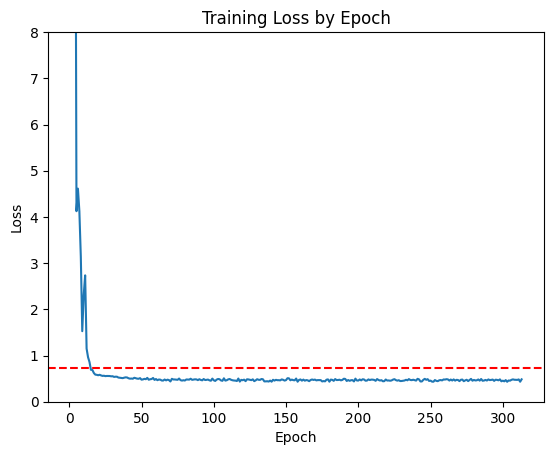

In [24]:
sns.lineplot(y=loss_values, x=epoch_values)

plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.axhline(y=ref, color='r', linestyle='--')

plt.ylim(0, 8)

plt.show()